In [3]:
#Cell 0 — Setup and paths
import os, json, math, random
from pathlib import Path
import numpy as np
from tqdm import tqdm

# >>> EDIT THESE TWO <<< 
DATA_ROOT = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")
RUN_ROOT  = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs")

# Create a fresh run dir every time to avoid mixing old/new outputs
RUN_DIR = RUN_ROOT / "run_clean_3"
if RUN_DIR.exists():
    print("⚠️ RUN_DIR exists; delete it if you want a truly clean run:", RUN_DIR)
RUN_DIR.mkdir(parents=True, exist_ok=True)

VELO_DIR = DATA_ROOT / "velodyne"
CAL_DIR  = DATA_ROOT / "calib"
LAB_DIR  = DATA_ROOT / "label_2"

# ROI / grid
X_RANGE = (0.0, 50.0)    # forward (m)
Y_RANGE = (-20.0, 20.0)  # left-right (m)
RES     = 0.20           # grid size (m) -> 0.2 m
H = int((X_RANGE[1]-X_RANGE[0]) / RES)
W = int((Y_RANGE[1]-Y_RANGE[0]) / RES)

# Feature dirs
FEAT_RAW_DIR = RUN_DIR / "bev_float"      # optional raw check
FEAT_OK_DIR  = RUN_DIR / "bev_2ch_norm"   # ✅ sanitized features used everywhere
GOLD_DIR     = RUN_DIR / "golden"
for d in (FEAT_RAW_DIR, FEAT_OK_DIR, GOLD_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Class set: vehicles only
VEH_CLASSES = {"Car", "Van", "Truck", "Tram"}  # adjust if you wish

# Small helpers
def all_fids():
    return sorted([p.stem for p in VELO_DIR.glob("*.bin")])

print("Frames:", len(all_fids()), "H×W:", H, "×", W)


Frames: 7481 H×W: 250 × 200


In [4]:
#Cell 1 — KITTI I/O helpers (calib, labels, points)
def read_calib(fid):
    R0_rect = None
    Tr_velo_to_cam = None
    with open(CAL_DIR / f"{fid}.txt") as f:
        for ln in f:
            if not ln.strip(): 
                continue
            key, val = ln.split(":", 1)
            arr = np.fromstring(val, sep=" ")
            if key == "R0_rect":
                R0_rect = arr.reshape(3,3)
            elif key in ("Tr_velo_to_cam", "Tr_velo2cam"):
                Tr_velo_to_cam = arr.reshape(3,4)
    assert R0_rect is not None and Tr_velo_to_cam is not None, f"bad calib for {fid}"
    # 4×4
    R0_4 = np.eye(4); R0_4[:3,:3] = R0_rect
    Tr_v2c_4 = np.eye(4); Tr_v2c_4[:3,:4] = Tr_velo_to_cam
    return R0_4, Tr_v2c_4

def load_points(fid):
    pts = np.fromfile(VELO_DIR / f"{fid}.bin", dtype=np.float32).reshape(-1,4)[:, :3]  # (N,3) x,y,z
    # ROI filter
    x,y,z = pts[:,0], pts[:,1], pts[:,2]
    m = (x>=X_RANGE[0])&(x<X_RANGE[1])&(y>=Y_RANGE[0])&(y<Y_RANGE[1])&(z>-5.0)&(z<3.0)
    return pts[m]

def load_labels(fid):
    """Return only vehicle 3D boxes: (h,w,l,x,y,z,ry)."""
    boxes=[]
    with open(LAB_DIR/f"{fid}.txt") as f:
        for ln in f:
            tok = ln.strip().split()
            if not tok: 
                continue
            cls = tok[0]
            if cls not in VEH_CLASSES: 
                continue
            h,w,l = map(float, tok[8:11])
            x,y,z = map(float, tok[11:14])  # camera coords
            ry    = float(tok[14])
            boxes.append((h,w,l,x,y,z,ry))
    return boxes


In [5]:
#Cell 2
def xy_to_hw(x, y):
    """KITTI Velodyne x (forward), y (left) -> BEV indices (h,w) with origin bottom-left."""
    h = np.floor((x - X_RANGE[0]) / RES).astype(int)
    w = np.floor((y - Y_RANGE[0]) / RES).astype(int)
    return h, w

def rect_to_velo_matrix(R0_rect_4, Tr_v2c_4):
    """Return T_rect->velo (4x4)."""
    T_c2v = np.linalg.inv(Tr_v2c_4)
    T_r2v = T_c2v @ np.linalg.inv(R0_rect_4)
    return T_r2v

def box_corners_3d(h,w,l,x,y,z,ry):
    """In rect camera coords; returns (8,3)."""
    # camera: x right, y down, z forward; KITTI boxes are centered at bottom face
    x_c = l/2*np.array([1,1,-1,-1,1,1,-1,-1])
    y_c = h*np.array([0,0,0,0,-1,-1,-1,-1])
    z_c = w/2*np.array([1,-1,-1,1,1,-1,-1,1])
    R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                  [          0, 1,          0],
                  [-np.sin(ry), 0, np.cos(ry)]])
    corners = np.vstack([x_c, y_c, z_c]).T @ R.T + np.array([x,y,z])
    return corners

def golden_mask_for_frame(fid):
    R0, Tr = read_calib(fid)
    T_r2v = rect_to_velo_matrix(R0, Tr)
    mask = np.zeros((H,W), np.uint8)
    for (hh,ww,ll,xc,yc,zc,ry) in load_labels(fid):
        # corners in rect -> velo
        cr = box_corners_3d(hh,ww,ll,xc,yc,zc,ry)
        cr_h = np.hstack([cr, np.ones((8,1))]) @ T_r2v.T
        xv, yv, zv = cr_h[:,0], cr_h[:,1], cr_h[:,2]
        # footprint in (x,y)
        xs = xv[[0,1,2,3]]; ys = yv[[0,1,2,3]]
        # rasterize polygon via coarse bbox (good enough for footprint)
        h0,w0 = xy_to_hw(xs.min(), ys.min())
        h1,w1 = xy_to_hw(xs.max(), ys.max())
        h0,w0 = max(0,h0), max(0,w0)
        h1,w1 = min(H-1,h1), min(W-1,w1)
        mask[h0:h1+1, w0:w1+1] = 1
    return mask


In [6]:
# Cell 3 — BEV feature builders (OCC + HAG) with per-cell quantile ground estimate

# ---- BEV grid & quantization params ----
RES = 0.20                               # meters per cell
X_MIN, X_MAX = 0.0, 51.2                 # forward range (m)
Y_MIN, Y_MAX = -25.6, 25.6               # left/right range (m)
Z_MIN, Z_MAX = -3.0, 1.0                 # vertical range (m)
Z_BINS = 32                              # vertical histogram bins

# Normalizations
OCC_CLAMP = 8.0                          # clamp occupancy to [0, OCC_CLAMP] before norm
GROUND_Q  = 0.15                         # per-cell quantile used as “ground” level
HAG_MIN, HAG_MAX = -1.0, 1.0             # HAG normalization window (meters)

# ---- Derived constants (do not change) ----
W = int(round((Y_MAX - Y_MIN) / RES))    # BEV width  (columns, Y axis)
H = int(round((X_MAX - X_MIN) / RES))    # BEV height (rows,   X axis)
Z_DH = (Z_MAX - Z_MIN) / Z_BINS
Z_EDGES = np.linspace(Z_MIN, Z_MAX, Z_BINS + 1, dtype=np.float32)
Z_CENT  = 0.5 * (Z_EDGES[:-1] + Z_EDGES[1:])       # bin centers (Z_BINS,)

# ---- I/O helpers ----
def load_velo_frame(fid: str) -> np.ndarray:
    """Load a KITTI velodyne frame -> (N,4) float32 [x,y,z,intensity]."""
    p = Path(VELO_DIR) / f"{fid}.bin"
    pts = np.fromfile(p, dtype=np.float32).reshape(-1, 4)
    return pts

def points_to_hist(pts: np.ndarray) -> np.ndarray:
    """
    Rasterize points into a (H, W, Z_BINS) integer histogram along Z.
    Grid axes: X → rows [0..H), Y → cols [0..W).
    """
    x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
    m = (x >= X_MIN) & (x < X_MAX) & (y >= Y_MIN) & (y < Y_MAX) & (z >= Z_MIN) & (z < Z_MAX)
    if not np.any(m):
        return np.zeros((H, W, Z_BINS), dtype=np.int32)
    x, y, z = x[m], y[m], z[m]

    xi = np.floor((x - X_MIN) / RES).astype(np.int32)      # 0..H-1
    yi = np.floor((y - Y_MIN) / RES).astype(np.int32)      # 0..W-1
    zi = np.floor((z - Z_MIN) / Z_DH).astype(np.int32)     # 0..Z_BINS-1

    # Safety clamps (robust to boundary hits)
    xi = np.clip(xi, 0, H - 1)
    yi = np.clip(yi, 0, W - 1)
    zi = np.clip(zi, 0, Z_BINS - 1)

    hist = np.zeros((H, W, Z_BINS), dtype=np.int32)
    np.add.at(hist, (xi, yi, zi), 1)
    return hist

# ---- Main feature builder (FIXED) ----
def bev_features(fid: str) -> np.ndarray:
    """
    Compute BEV features for frame `fid`.

    Returns:
        X: float32 array (2, H, W)
           channel 0: OCC normalized to [0,1]
           channel 1: HAG normalized to [0,1], where
                      HAG = z_mean - ground_z and ground_z is the per-cell
                      GROUND_Q quantile of the local height distribution.
    """
    pts  = load_velo_frame(fid)
    hist = points_to_hist(pts)                               # (H, W, Z)

    occ  = hist.sum(axis=2).astype(np.int32)                 # (H, W)
    csum = hist.cumsum(axis=2)                               # (H, W, Z)

    # ---- FIX: per-cell quantile as an array (no scalar cast) ----
    q = np.ceil(GROUND_Q * np.clip(occ, 1, None)).astype(np.int32)    # (H, W)
    idx = np.argmax(csum >= q[..., None], axis=2).astype(np.int32)     # (H, W)
    idx[occ == 0] = 0

    # z_mean and height-above-ground
    z_sum   = (hist * Z_CENT[None, None, :]).sum(axis=2)              # (H, W)
    z_mean  = z_sum / np.clip(occ, 1, None)
    ground_z = Z_CENT[idx]
    hag     = z_mean - ground_z

    # Normalize
    occ_norm = np.clip(occ / OCC_CLAMP, 0, 1).astype(np.float32)
    hag_norm = np.clip((hag - HAG_MIN) / (HAG_MAX - HAG_MIN + 1e-6), 0, 1).astype(np.float32)

    X = np.stack([occ_norm, hag_norm], axis=0).astype(np.float32)     # (2, H, W)
    return X

# ---- Convenience: list all frame IDs ----
ALL_FIDS = sorted([p.stem for p in Path(VELO_DIR).glob("*.bin")])

print(f"Cell 3 ready ✓  grid={H}x{W} @ {RES:.2f}m, Z_BINS={Z_BINS}, frames={len(ALL_FIDS)}")


Cell 3 ready ✓  grid=256x256 @ 0.20m, Z_BINS=32, frames=7481


In [7]:
# Cell 4 — Export features + golden and SPLIT into train/val/test

import os, random, numpy as np
from pathlib import Path
from tqdm import tqdm

# expects from Cell 3:
#  - ALL_FIDS : list of all frame IDs (strings like "000123")
#  - bev_features(fid) -> (2,H,W) float32, channels: (OCC_norm, HAG_norm)
# and from your labels cell:
#  - golden_mask_for_frame(fid) -> (H,W) uint8 (1=vehicle,0=background)

# -------- settings you can tweak --------
SPLIT = dict(train=0.80, val=0.10, test=0.10)  # must sum to 1.0
SEED  = 42
SUBSET_MAX = None   # e.g. 3000 to cap frames used; None = use all
SKIP_IF_EXISTS = True
DS_NAME = "dataset_2ch_split"  # dataset folder name under RUN_DIR
# ---------------------------------------

# Where to write (reuse RUN_DIR if you already set it earlier)
try:
    RUN_DIR
except NameError:
    RUN_DIR = Path("./outputs/run_split")
DS_DIR = RUN_DIR / DS_NAME
for split in ("train","val","test"):
    (DS_DIR/split).mkdir(parents=True, exist_ok=True)

# choose frames
FIDS = sorted(ALL_FIDS)
if SUBSET_MAX is not None:
    FIDS = FIDS[:SUBSET_MAX]
random.Random(SEED).shuffle(FIDS)

n = len(FIDS)
n_train = int(round(n * SPLIT["train"]))
n_val   = int(round(n * SPLIT["val"]))
n_test  = n - n_train - n_val
SPLITS = {
    "train": FIDS[:n_train],
    "val":   FIDS[n_train:n_train+n_val],
    "test":  FIDS[n_train+n_val:],
}
print(f"frames: total={n}  train={len(SPLITS['train'])}  val={len(SPLITS['val'])}  test={len(SPLITS['test'])}")
print("writing to:", DS_DIR)

def export_one(fid: str, split: str):
    x = bev_features(fid).astype(np.float32)      # (2,H,W)
    y = golden_mask_for_frame(fid).astype(np.uint8)  # (H,W)
    np.save(DS_DIR/split/f"{fid}_x.npy", x)
    np.save(DS_DIR/split/f"{fid}_y.npy", y)

for split, ids in SPLITS.items():
    pbar = tqdm(ids, desc=f"export {split}", leave=False)
    for fid in pbar:
        x_path = DS_DIR/split/f"{fid}_x.npy"
        y_path = DS_DIR/split/f"{fid}_y.npy"
        if SKIP_IF_EXISTS and x_path.exists() and y_path.exists():
            continue
        export_one(fid, split)

# quick sanity: count files + approximate positive fraction in each split
def pos_frac(split, sample=400):
    ys = sorted((DS_DIR/split).glob("*_y.npy"))
    if not ys: return 0.0
    pick = ys if len(ys) <= sample else random.sample(ys, sample)
    pos = tot = 0
    for yp in pick:
        y = np.load(yp)
        pos += int(y.sum()); tot += y.size
    return pos / max(tot,1)

for split in ("train","val","test"):
    nx = len(list((DS_DIR/split).glob("*_x.npy")))
    ny = len(list((DS_DIR/split).glob("*_y.npy")))
    pf = pos_frac(split)
    print(f"{split:5s} | files x={nx} y={ny} | approx pos%={pf*100:.3f}")
print("Cell 4 split export ✓")


frames: total=7481  train=5985  val=748  test=748
writing to: D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs\run_clean_3\dataset_2ch_split


train | files x=5985 y=5985 | approx pos%=1.859
val   | files x=748 y=748 | approx pos%=1.660
test  | files x=748 y=748 | approx pos%=1.643
Cell 4 split export ✓


In [8]:
# Cell 5 — Balance negatives (keep all positives), keep val/test intact

# source from Cell 4
DS_SRC = RUN_DIR / "dataset_2ch_split"    # <- created by Cell 4
# destination used by next cells
DS_DIR = RUN_DIR / "dataset_2ch_balanced"
for s in ("train","val","test"):
    (DS_DIR/s).mkdir(parents=True, exist_ok=True)

NEG_KEEP_FRAC = 0.25   # keep 25% of pure-negative frames in *train*
SEED = 42
rng = random.Random(SEED)

def build_split(split: str):
    kept = 0; tot = 0
    xs = sorted((DS_SRC/split).glob("*_x.npy"))
    for xp in tqdm(xs, desc=f"build {split}"):
        yp = Path(str(xp).replace("_x.npy", "_y.npy"))
        if not yp.exists(): 
            continue
        X = np.load(xp).astype(np.float32)   # (2,H,W)  (OCC_norm, HAG_norm)
        Y = np.load(yp).astype(np.uint8)     # (H,W), 1=vehicle
        tot += 1
        if split == "train" and Y.sum() == 0:
            if rng.random() > NEG_KEEP_FRAC:
                continue  # drop some all-negative frames
        out_x = DS_DIR/split/xp.name
        out_y = DS_DIR/split/yp.name
        np.save(out_x, X); np.save(out_y, Y)
        kept += 1
    return kept, tot

stats = {}
for s in ("train","val","test"):
    stats[s] = build_split(s)

print("kept/total:", stats, "| dst:", DS_DIR)


build test: 100%|████████████████████████████████████████████████████████████████████| 748/748 [00:44<00:00, 16.96it/s]

kept/total: {'train': (5497, 5985), 'val': (748, 748), 'test': (748, 748)} | dst: D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs\run_clean_3\dataset_2ch_balanced


train | x=5497 y=5497 | approx pos%=1.913
val   | x=748 y=748 | approx pos%=1.696
test  | x=748 y=748 | approx pos%=1.611


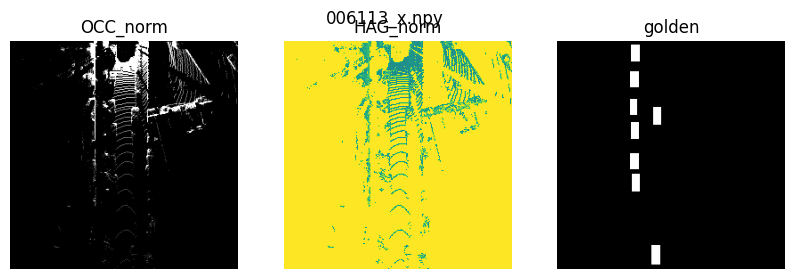

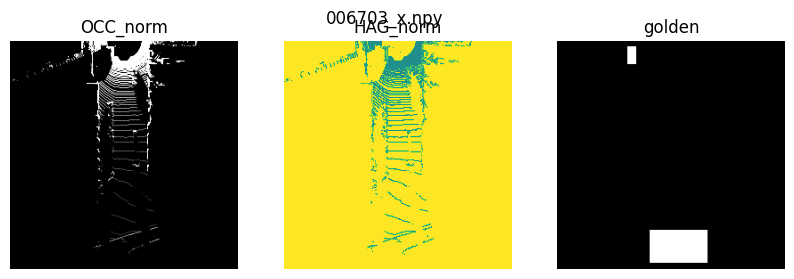

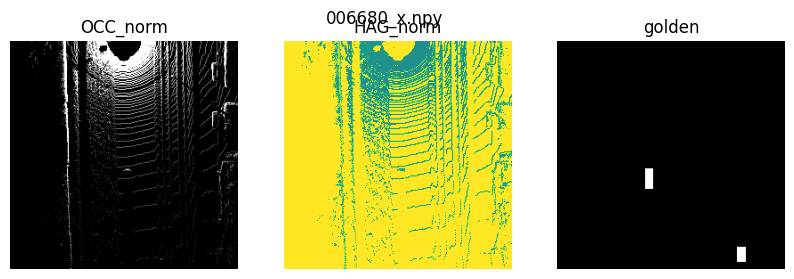

Cell 6 ✓


In [9]:
# Cell 6 — Sanity check counts, pos%, and visualize a couple of samples

import numpy as np, random
from pathlib import Path
import matplotlib.pyplot as plt

def pos_frac(split, sample=400):
    ys = sorted((DS_DIR/split).glob("*_y.npy"))
    if not ys: return 0.0
    pick = ys if len(ys) <= sample else random.sample(ys, sample)
    pos = tot = 0
    for yp in pick:
        y = np.load(yp); pos += int(y.sum()); tot += y.size
    return pos/max(tot,1)

for s in ("train","val","test"):
    nx = len(list((DS_DIR/s).glob("*_x.npy")))
    ny = len(list((DS_DIR/s).glob("*_y.npy")))
    print(f"{s:5s} | x={nx} y={ny} | approx pos%={100*pos_frac(s):.3f}")

# visualize a few random samples from val
show_k = 3
val_xs = sorted((DS_DIR/"val").glob("*_x.npy"))
pick = random.sample(val_xs, min(show_k, len(val_xs)))
for xp in pick:
    yp = Path(str(xp).replace("_x.npy","_y.npy"))
    X = np.load(xp)            # (2,H,W)
    Y = np.load(yp)            # (H,W)
    fig,ax = plt.subplots(1,3,figsize=(10,3))
    ax[0].imshow(X[0], cmap="gray", vmin=0, vmax=1); ax[0].set_title("OCC_norm"); ax[0].axis("off")
    ax[1].imshow(X[1], cmap="viridis", vmin=0, vmax=1); ax[1].set_title("HAG_norm"); ax[1].axis("off")
    ax[2].imshow(Y, cmap="gray"); ax[2].set_title("golden"); ax[2].axis("off")
    fig.suptitle(xp.name)
    plt.show()

print("Cell 6 ✓")


In [45]:
# Cell 7 — Train tiny BEV segmenter (2-ch), with pos_weight and IoU tracking

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np, random
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IN_CH   = 2
BATCH   = 16
EPOCHS  = 15
LR      = 1e-3

class NpyPairs(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.xs = sorted(self.root.glob("*_x.npy"))
        self.ys = [Path(str(p).replace("_x.npy","_y.npy")) for p in self.xs]
        assert len(self.xs)==len(self.ys)>0
        # estimate pos_weight from ~300 masks
        pos, tot = 0, 0
        for yp in self.ys[:min(300,len(self.ys))]:
            y = np.load(yp).astype(np.uint8)
            pos += y.sum(); tot += y.size
        self.pos_weight = float((tot-pos)/max(pos,1))

    def __len__(self): return len(self.xs)

    def __getitem__(self, i):
        x = np.load(self.xs[i]).astype(np.float32)      # (2,H,W)
        y = np.load(self.ys[i]).astype(np.uint8)        # (H,W)
        x = torch.from_numpy(x)                         # (C,H,W)
        y = torch.from_numpy(y[None,:,:].astype(np.float32))  # (1,H,W)
        return x, y

train_ds = NpyPairs(DS_DIR/"train")
val_ds   = NpyPairs(DS_DIR/"val")
print(f"tiles: train={len(train_ds)}  val={len(val_ds)}  in_ch={IN_CH}  pos_w≈{train_ds.pos_weight:.2f}")

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0)

# tiny U-Net-ish head
class TinyUNet(nn.Module):
    def __init__(self, in_ch=2, base=16):
        super().__init__()
        self.e1 = nn.Sequential(nn.Conv2d(in_ch, base, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base, base, 3, padding=1), nn.ReLU())
        self.p1 = nn.MaxPool2d(2)
        self.e2 = nn.Sequential(nn.Conv2d(base, base*2, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base*2, base*2, 3, padding=1), nn.ReLU())
        self.p2 = nn.MaxPool2d(2)
        self.b  = nn.Sequential(nn.Conv2d(base*2, base*4, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base*4, base*4, 3, padding=1), nn.ReLU())
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.d2 = nn.Sequential(nn.Conv2d(base*4, base*2, 3, padding=1), nn.ReLU())
        self.u1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.d1 = nn.Sequential(nn.Conv2d(base*2, base, 3, padding=1), nn.ReLU())
        self.out = nn.Conv2d(base, 1, 1)
    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.p1(e1))
        b  = self.b(self.p2(e2))
        d2 = self.u2(b); d2 = self.d2(torch.cat([d2, e2], dim=1))
        d1 = self.u1(d2); d1 = self.d1(torch.cat([d1, e1], dim=1))
        return self.out(d1)  # (B,1,H,W)

model = TinyUNet(IN_CH).to(device)

bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([train_ds.pos_weight], device=device))
opt = torch.optim.Adam(model.parameters(), lr=LR)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=4, verbose=False)

def eval_iou(loader, thr=0.5):
    model.eval(); inter=0; union=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            pr = (torch.sigmoid(model(xb))>thr).float()
            inter += (pr*yb).sum().item()
            union += (pr+yb - pr*yb).sum().item()
    return 0.0 if union==0 else inter/union

best_iou, best_path = 0.0, RUN_DIR/"tiny_bev.pt"
for ep in range(1, EPOCHS+1):
    model.train(); tot=0; n=0
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = bce(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*xb.size(0); n += xb.size(0)
    i30 = eval_iou(val_loader, 0.30)
    i40 = eval_iou(val_loader, 0.40)
    i50 = eval_iou(val_loader, 0.50)
    sch.step(1.0 - i50)
    print(f"epoch {ep:02d} | train_loss {tot/max(n,1):.4f} | val IoU t0.30:{i30:.3f} t0.40:{i40:.3f} t0.50:{i50:.3f}")
    if i50 > best_iou:
        best_iou = i50
        torch.save(model.state_dict(), best_path)
print("saved model to:", best_path)


tiles: train=5497  val=748  in_ch=2  pos_w≈47.71


C:\Users\DELL\anaconda3\envs\pointpillars\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


epoch 01 | train_loss 1.2450 | val IoU t0.30:0.026 t0.40:0.028 t0.50:0.031
epoch 02 | train_loss 1.1460 | val IoU t0.30:0.027 t0.40:0.029 t0.50:0.032
epoch 03 | train_loss 1.1294 | val IoU t0.30:0.028 t0.40:0.029 t0.50:0.031
epoch 04 | train_loss 1.1123 | val IoU t0.30:0.028 t0.40:0.030 t0.50:0.033
epoch 05 | train_loss 1.0938 | val IoU t0.30:0.027 t0.40:0.029 t0.50:0.032
epoch 06 | train_loss 1.0780 | val IoU t0.30:0.029 t0.40:0.032 t0.50:0.038
epoch 07 | train_loss 1.0696 | val IoU t0.30:0.028 t0.40:0.030 t0.50:0.033
epoch 08 | train_loss 1.0538 | val IoU t0.30:0.029 t0.40:0.032 t0.50:0.038
epoch 09 | train_loss 1.0397 | val IoU t0.30:0.030 t0.40:0.033 t0.50:0.038
epoch 10 | train_loss 1.0343 | val IoU t0.30:0.032 t0.40:0.037 t0.50:0.047
epoch 11 | train_loss 1.0216 | val IoU t0.30:0.028 t0.40:0.030 t0.50:0.035
epoch 12 | train_loss 1.0113 | val IoU t0.30:0.031 t0.40:0.034 t0.50:0.040
epoch 13 | train_loss 1.0048 | val IoU t0.30:0.032 t0.40:0.036 t0.50:0.043
epoch 14 | train_loss 0.9

In [10]:
# Cell 7_New — Stronger tiny BEV segmenter with Dice, cap pos_weight, light aug

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np, random
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IN_CH   = 2          # set to 3 if you add zvar/density in the export
BATCH   = 16
EPOCHS  = 70
LR      = 1e-3
POSW_CAP = 25.0      # <-- cap the imbalance weight

class NpyPairs(Dataset):
    def __init__(self, root, augment=False):
        self.root = Path(root)
        self.xs = sorted(self.root.glob("*_x.npy"))
        self.ys = [Path(str(p).replace("_x.npy","_y.npy")) for p in self.xs]
        assert len(self.xs)==len(self.ys)>0
        # estimate pos_weight
        pos, tot = 0, 0
        for yp in self.ys[:min(300,len(self.ys))]:
            y = np.load(yp).astype(np.uint8)
            pos += y.sum(); tot += y.size
        raw_pw = float((tot-pos)/max(pos,1))
        self.pos_weight = float(min(POSW_CAP, raw_pw))
        self.augment = augment

    def __len__(self): return len(self.xs)

    def _augment(self, x, y):
        # 90° rotations
        k = random.randint(0,3)
        x = np.rot90(x, k, axes=(1,2))  # (C,H,W)
        y = np.rot90(y, k)              # (H,W)
        # horizontal flip (along W)
        if random.random()<0.5:
            x = x[:, :, ::-1]
            y = y[:, ::-1]
        # tiny Gaussian noise on OCC only
        if random.random()<0.5:
            x[0] = np.clip(x[0] + np.random.normal(0, 0.02, x[0].shape), 0, 1)
        return x, y

    def __getitem__(self, i):
        x = np.load(self.xs[i]).astype(np.float32)  # (C,H,W)
        y = np.load(self.ys[i]).astype(np.uint8)    # (H,W)
        if self.augment:
            x, y = self._augment(x, y)
        x = torch.from_numpy(x)
        y = torch.from_numpy(y[None, :, :].astype(np.float32))
        return x, y

train_ds = NpyPairs(DS_DIR/"train", augment=True)
val_ds   = NpyPairs(DS_DIR/"val",   augment=False)
print(f"tiles: train={len(train_ds)}  val={len(val_ds)}  in_ch={IN_CH}  pos_w≈{train_ds.pos_weight:.2f}")

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0)

# Tiny UNet with a bit more width + BatchNorm
class TinyUNet(nn.Module):
    def __init__(self, in_ch=IN_CH, base=32):
        super().__init__()
        def blk(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
                nn.Conv2d(cout, cout, 3, padding=1), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
            )
        self.e1 = blk(in_ch, base)
        self.p1 = nn.MaxPool2d(2)
        self.e2 = blk(base, base*2)
        self.p2 = nn.MaxPool2d(2)
        self.b  = blk(base*2, base*4)
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.d2 = nn.Sequential(nn.Conv2d(base*4, base*2, 3, padding=1), nn.BatchNorm2d(base*2), nn.ReLU(inplace=True))
        self.u1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.d1 = nn.Sequential(nn.Conv2d(base*2, base, 3, padding=1), nn.BatchNorm2d(base), nn.ReLU(inplace=True))
        self.out = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.p1(e1))
        b  = self.b(self.p2(e2))
        d2 = self.u2(b); d2 = self.d2(torch.cat([d2, e2], dim=1))
        d1 = self.u1(d2); d1 = self.d1(torch.cat([d1, e1], dim=1))
        return self.out(d1)

model = TinyUNet().to(device)

bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([train_ds.pos_weight], device=device))

def soft_dice_loss(logits, y, eps=1e-6):
    p = torch.sigmoid(logits)
    inter = (2.0 * (p*y).sum(dim=(1,2,3)) + eps)
    denom = (p.sum(dim=(1,2,3)) + y.sum(dim=(1,2,3)) + eps)
    return 1.0 - (inter/denom).mean()

opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

def eval_iou(loader, thr=0.5):
    model.eval(); inter=0; union=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            pr = (torch.sigmoid(model(xb)) > thr).float()
            inter += (pr*yb).sum().item()
            union += (pr+yb - pr*yb).sum().item()
    return 0.0 if union==0 else inter/union

best_iou, best_path = 0.0, RUN_DIR/"tiny_bev.pt"
for ep in range(1, EPOCHS+1):
    model.train(); tot=0; n=0
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = bce(logits, yb) + 0.5*soft_dice_loss(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*xb.size(0); n += xb.size(0)
    i30 = eval_iou(val_loader, 0.30)
    i40 = eval_iou(val_loader, 0.40)
    i50 = eval_iou(val_loader, 0.50)
    sch.step()
    print(f"epoch {ep:02d} | train_loss {tot/max(n,1):.4f} | val IoU t0.30:{i30:.3f} t0.40:{i40:.3f} t0.50:{i50:.3f}")
    if i50 > best_iou:
        best_iou = i50
        torch.save(model.state_dict(), best_path)
print("saved model to:", best_path)


tiles: train=5497  val=748  in_ch=2  pos_w≈25.00


ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 

In [12]:
# Cell 7_New — Stronger tiny BEV segmenter with Dice, cap pos_weight, light aug
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np, random
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IN_CH   = 2          # set to 3 if you also exported zvar/density
BATCH   = 16
EPOCHS  = 70
LR      = 1e-3
POSW_CAP = 25.0

class NpyPairs(Dataset):
    def __init__(self, root, augment=False):
        self.root = Path(root)
        self.xs = sorted(self.root.glob("*_x.npy"))
        self.ys = [Path(str(p).replace("_x.npy","_y.npy")) for p in self.xs]
        assert len(self.xs)==len(self.ys)>0
        pos, tot = 0, 0
        for yp in self.ys[:min(300,len(self.ys))]:
            y = np.load(yp).astype(np.uint8)
            pos += y.sum(); tot += y.size
        raw_pw = float((tot-pos)/max(pos,1))
        self.pos_weight = float(min(POSW_CAP, raw_pw))
        self.augment = augment

    def __len__(self): return len(self.xs)

    def _augment(self, x, y):
        # rotate k*90°
        k = random.randint(0,3)
        if k:
            x = np.rot90(x, k, axes=(1,2)).copy()   # copy -> positive strides
            y = np.rot90(y, k).copy()
        # horizontal flip
        if random.random() < 0.5:
            x = np.flip(x, axis=2).copy()
            y = np.flip(y, axis=1).copy()
        # tiny Gaussian noise on OCC (ch 0)
        if random.random() < 0.5:
            x0 = x[0] + np.random.normal(0, 0.02, x[0].shape)
            x[0] = np.clip(x0, 0.0, 1.0)
        return x, y

    def __getitem__(self, i):
        x = np.load(self.xs[i]).astype(np.float32)   # (C,H,W)
        y = np.load(self.ys[i]).astype(np.uint8)     # (H,W)
        if self.augment:
            x, y = self._augment(x, y)
        # ensure contiguous with positive strides before torch
        x = np.ascontiguousarray(x, dtype=np.float32)
        y = np.ascontiguousarray(y[None, :, :], dtype=np.float32)  # (1,H,W)
        return torch.from_numpy(x), torch.from_numpy(y)

# ---- data ----
train_ds = NpyPairs(DS_DIR/"train", augment=True)
val_ds   = NpyPairs(DS_DIR/"val",   augment=False)
print(f"tiles: train={len(train_ds)}  val={len(val_ds)}  in_ch={IN_CH}  pos_w≈{train_ds.pos_weight:.2f}")

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# ---- model ----
class TinyUNet(nn.Module):
    def __init__(self, in_ch=IN_CH, base=32):
        super().__init__()
        def blk(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
                nn.Conv2d(cout, cout, 3, padding=1), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
            )
        self.e1 = blk(in_ch, base);    self.p1 = nn.MaxPool2d(2)
        self.e2 = blk(base, base*2);   self.p2 = nn.MaxPool2d(2)
        self.b  = blk(base*2, base*4)
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.d2 = nn.Sequential(nn.Conv2d(base*4, base*2, 3, padding=1), nn.BatchNorm2d(base*2), nn.ReLU(inplace=True))
        self.u1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.d1 = nn.Sequential(nn.Conv2d(base*2, base, 3, padding=1), nn.BatchNorm2d(base), nn.ReLU(inplace=True))
        self.out = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.p1(e1))
        b  = self.b(self.p2(e2))
        d2 = self.u2(b); d2 = self.d2(torch.cat([d2, e2], dim=1))
        d1 = self.u1(d2); d1 = self.d1(torch.cat([d1, e1], dim=1))
        return self.out(d1)  # (B,1,H,W)

model = TinyUNet().to(device)

# ---- losses & optim ----
bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([train_ds.pos_weight], device=device))

def soft_dice_loss(logits, y, eps=1e-6):
    p = torch.sigmoid(logits)
    inter = (2.0 * (p*y).sum(dim=(1,2,3)) + eps)
    denom = (p.sum(dim=(1,2,3)) + y.sum(dim=(1,2,3)) + eps)
    return 1.0 - (inter/denom).mean()

opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

# ---- eval ----
def eval_iou(loader, thr=0.5):
    model.eval(); inter=0; union=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            pr = (torch.sigmoid(model(xb)) > thr).float()
            inter += (pr*yb).sum().item()
            union += (pr+yb - pr*yb).sum().item()
    return 0.0 if union==0 else inter/union

# ---- train ----
best_iou, best_path = 0.0, RUN_DIR/"tiny_bev.pt"
for ep in range(1, EPOCHS+1):
    model.train(); tot=0; n=0
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = bce(logits, yb) + 0.5*soft_dice_loss(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*xb.size(0); n += xb.size(0)
    i30 = eval_iou(val_loader, 0.30)
    i40 = eval_iou(val_loader, 0.40)
    i50 = eval_iou(val_loader, 0.50)
    sch.step()
    print(f"epoch {ep:02d} | train_loss {tot/max(n,1):.4f} | val IoU t0.30:{i30:.3f} t0.40:{i40:.3f} t0.50:{i50:.3f}")
    if i50 > best_iou:
        best_iou = i50
        torch.save(model.state_dict(), best_path)
print("saved model to:", best_path)


tiles: train=5497  val=748  in_ch=2  pos_w≈25.00
epoch 01 | train_loss 1.3394 | val IoU t0.30:0.026 t0.40:0.029 t0.50:0.035
epoch 02 | train_loss 1.3142 | val IoU t0.30:0.026 t0.40:0.030 t0.50:0.038
epoch 03 | train_loss 1.3094 | val IoU t0.30:0.029 t0.40:0.033 t0.50:0.040
epoch 04 | train_loss 1.3062 | val IoU t0.30:0.028 t0.40:0.033 t0.50:0.040
epoch 05 | train_loss 1.3007 | val IoU t0.30:0.028 t0.40:0.034 t0.50:0.040
epoch 06 | train_loss 1.2977 | val IoU t0.30:0.030 t0.40:0.034 t0.50:0.040
epoch 07 | train_loss 1.2951 | val IoU t0.30:0.027 t0.40:0.032 t0.50:0.038
epoch 08 | train_loss 1.2909 | val IoU t0.30:0.029 t0.40:0.034 t0.50:0.040
epoch 09 | train_loss 1.2902 | val IoU t0.30:0.028 t0.40:0.034 t0.50:0.047
epoch 10 | train_loss 1.2879 | val IoU t0.30:0.032 t0.40:0.039 t0.50:0.046
epoch 11 | train_loss 1.2859 | val IoU t0.30:0.029 t0.40:0.034 t0.50:0.041
epoch 12 | train_loss 1.2831 | val IoU t0.30:0.033 t0.40:0.042 t0.50:0.047
epoch 13 | train_loss 1.2821 | val IoU t0.30:0.030 

In [ ]:
# Cell 8 — Best threshold sweep + visualize a few predictions

import numpy as np, torch, matplotlib.pyplot as plt
from pathlib import Path

thr_grid = np.linspace(0.2, 0.8, 25)

# reload best model
m = TinyUNet(IN_CH).to(device)
best_path = RUN_DIR/"tiny_bev.pt"
m.load_state_dict(torch.load(best_path, map_location=device))
m.eval()

def iou_at_thr(thr):
    return eval_iou(val_loader, thr)

scores = [iou_at_thr(t) for t in thr_grid]
best_idx = int(np.argmax(scores))
best_thr = float(thr_grid[best_idx])
print(f"VAL best IoU={scores[best_idx]:.3f} at thr={best_thr:.2f}")

# visualize a few samples from val
with torch.no_grad():
    xs = sorted((DS_DIR/"val").glob("*_x.npy"))
    for xp in random.sample(xs, min(3, len(xs))):
        yp = Path(str(xp).replace("_x.npy","_y.npy"))
        X = torch.from_numpy(np.load(xp).astype(np.float32)).unsqueeze(0).to(device)  # (1,2,H,W)
        Y = np.load(yp).astype(np.uint8)
        P = torch.sigmoid(m(X))[0,0].cpu().numpy()
        fig,ax = plt.subplots(1,3,figsize=(10,3))
        ax[0].imshow(P, cmap="magma"); ax[0].set_title("pred prob"); ax[0].axis("off")
        ax[1].imshow((P>best_thr).astype(np.uint8)*255, cmap="gray"); ax[1].set_title(f"pred bin t={best_thr:.2f}"); ax[1].axis("off")
        ax[2].imshow(Y, cmap="gray"); ax[2].set_title("golden"); ax[2].axis("off")
        fig.suptitle(xp.name); plt.show()

print("Cell 8 ✓")
